# **YOLO Instance Segmentation**
***

In [1]:
from ultralytics import YOLO
import torch
import time
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort
from PIL import Image
import cv2.dnn
import matplotlib

***
**Datenset im YOLO Format generieren**

In [2]:
validation_set_size = 0.2
test_set_size = 0.1

In [3]:
labelme_json_path = "dataset"
yolo_dataset_path = "dataset/YOLOv8Dataset"

In [4]:
if os.path.exists(yolo_dataset_path):
    print("Dataset already existing...")
    print("Generate new dataset?")
else:
    print("Generating YOLOv8 Dataset...")
    !python -m labelme2yolov8 --json_dir {labelme_json_path} --val_size {validation_set_size} --test_size {test_set_size}
    print("Done!")

Dataset already existing...
Generate new dataset?


In [5]:
generate_new_dataset = False

if generate_new_dataset:
    print("Deleting old dataset...")
    shutil.rmtree(yolo_dataset_path)
    print("Generate new dataset...")
    !pip install labelme2yolov8
    !python -m labelme2yolov8 --json_dir {labelme_json_path} --val_size {validation_set_size} --test_size {test_set_size}
    print("Done!")
else:
    print("Using existing dataset!")

Using existing dataset!


***
**Modell laden**

In [6]:
use_new_model = False
selected_model = "nano"         # nano -> small -> medium -> large -> xlarge

if use_new_model:
    print("Load new model...")
    if selected_model == "nano":
        model = YOLO("yolo11n-seg.pt")
    elif selected_model == "small":
        model = YOLO("yolov8s-seg.pt")
    elif selected_model == "medium":
        model = YOLO("yolov8m-seg.pt")
    elif selected_model == "large":
        model = YOLO("yolov8l-seg.pt")
    elif selected_model == "xlarge":
        model = YOLO("yolov8x-seg.pt")

else:
    print("Load saved model...")
    if selected_model == "nano":
        model = YOLO(r"/home/mo/YoloV8_InstanceSeg/models/20250110_2023_yolo8nano_pruned.pt")
    elif selected_model == "small":
        model = YOLO(r"C:\Users\morit\Desktop\YoloV8_InstanceSeg\models\20250111_1258_best_small.pt")
    elif selected_model == "medium":
        model = YOLO(r"C:\Users\morit\Desktop\YoloV8_InstanceSeg\models\best_medium.pt")
    elif selected_model == "large":
        model = YOLO(r"C:\Users\morit\Desktop\YoloV8_InstanceSeg\models\best_large.pt")
    elif selected_model == "xlarge":
        model = YOLO(r"C:\Users\morit\Desktop\YoloV8_InstanceSeg\models\best_xlarge.pt")

print("Model loaded successfully!") if model is not None else print("Model load failed!")

Load saved model...
Model loaded successfully!


In [7]:
use_gpu = True

if use_gpu and torch.cuda.is_available():
    device = "cuda"
    print("Using GPU!\n\n")
    !nvidia-smi
else:
    device = "cpu"
    print("Using CPU!")

Using GPU!


Tue Jan 14 17:32:33 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8              15W /  25W |     17MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------------

***
**Training**

In [8]:
train_mode = False

In [9]:
yaml_path = r"/home/mo/YoloV8_InstanceSeg/dataset/YOLOv8Dataset/dataset.yaml"         # Dataset Config YAML file

In [10]:
num_epochs = 1000

learning_rate = 1e-4
optimizer = "Adam"      # SGD, Adam, AdamW, NAdam, RAdam, RMSProp
dropout_rate = 0.0
use_validation = True
save_plots = True

max_train_time_in_hours = None          # max Trainingszeit in h -> wenn None, dann volle Epochen
batch_size = -1                         # -1 setzt Batches automatisch, sodass GPU-Speicher 60% genutzt
save_every_x_epochs = -1                # Automatische Speicherung alle x Epoche -> wenn -1, dann deaktiviert
change_picture_scale = True             # veraendert die Bildgroesse waehrend Training
merge_seg_masks = False                 # Masken zusammenführen -> für Instance Segmentation ungeeignet

In [11]:
if train_mode:
    train_results = model.train(
        data=yaml_path,
        epochs=num_epochs,
        lr0=learning_rate,
        optimizer=optimizer,
        dropout=dropout_rate,
        val = use_validation,
        plots = save_plots,
        time = max_train_time_in_hours,
        batch = batch_size,
        save_period = save_every_x_epochs,
        multi_scale = change_picture_scale,
        overlap_mask = merge_seg_masks,
        imgsz=640,
        device=device
    )

***
**Single Image Inference**

In [52]:
img_path = r"/home/mo/YoloV8_InstanceSeg/dataset/image_1735929919.png"
img_path = r"/home/mo/Bilder/Bildschirmfoto von 2025-01-14 17-30-53.png"
frame = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)

In [53]:
print(frame_rgb.shape)

(89, 550, 3)


In [54]:
confidence_threshold = 0.4
max_hooks = 100

In [55]:
start_time = time.perf_counter()

results = model.predict(source = frame_rgb,
                            device=device,
                            conf = confidence_threshold,
                            iou = 0.7,
                            max_det = max_hooks,
                            visualize = False,
                            classes = [0, 1, 2, 3],
                            retina_masks = True,
                            show_conf=False,
                            show_boxes=False,
                            show_labels=True,
                            save=False,
                            show=False,
                            save_txt=False,
                            save_crop=False,
                            line_width=2,
                            box=False)

end_time = time.perf_counter()

print(f"\nInferenz-Laufzeit: {end_time- start_time:.5f} sec")
print(f"Durchschnittliche FPS: {1/(end_time-start_time):.4f}")


0: 128x640 2 hooks, 2 tips, 12.2ms
Speed: 1.7ms preprocess, 12.2ms inference, 3.3ms postprocess per image at shape (1, 3, 128, 640)

Inferenz-Laufzeit: 0.02291 sec
Durchschnittliche FPS: 43.6526


**Postprocessing über CPU**

In [56]:
boxes, masks, confs, classes = extract_output(results)
boxes_bar, masks_bar, confs_bar, boxes_hooks, masks_hooks, boxes_tips, masks_tips, boxes_lowpoints, masks_lowpoints, confs_hooks, confs_tips, confs_lowpoints = split_outputs_by_class(boxes, masks, confs, classes)
hooks_dict = create_hook_instances(boxes_hooks, masks_hooks, 
                          boxes_tips, masks_tips, 
                          boxes_lowpoints, masks_lowpoints, 
                          confs_hooks, confs_tips, confs_lowpoints)
bar_dict = create_bar_instance(boxes_bar, masks_bar, confs_bar)

Bounding Boxes found!
Masks found!


In [35]:
def extract_output(results):
    res = results[0]

    if len(res.boxes.data.cpu().numpy()) != 0:
        print("Bounding Boxes found!")
        boxes = res.boxes.data.cpu().numpy()
        confs = [0, 0, 0, 0, 1, 0] * boxes
        confs = confs[:, 4:5]
        classes = [0, 0, 0, 0, 0, 1] * boxes
        classes = classes[:, 5:6]
        boxes = boxes[:, 0:4]
    else:
        print("No Bounding Boxes found!")
        boxes = None
        confs = None
        classes = None

    if res.masks:
        print("Masks found!")
        masks = res.masks.data.cpu().numpy()
    else:
        print("No Masks found!")
        masks = None

    return boxes, masks, confs, classes

def calc_box_midpoint(box):
    return np.array([(box[0] + box[2]) / 2, (box[1] + box[3]) / 2])

def box_distance(box1, box2):
    m1 = calc_box_midpoint(box1)
    m2 = calc_box_midpoint(box2)
    return abs(np.linalg.norm(m1, m2))

def split_outputs_by_class(boxes, masks, confs, classes):
    # Klassen Indizes finden
    if boxes is not None and masks is not None and confs is not None and classes is not None:
        idx_bar = np.where(classes == 0)[0]
        idx_hooks = np.where(classes == 1)[0]
        idx_tips = np.where(classes == 2)[0]
        idx_lowpoints = np.where(classes == 3)[0]

        # Boxes splitten
        boxes_bar = boxes[idx_bar]
        boxes_hooks = boxes[idx_hooks]
        boxes_tips = boxes[idx_tips]
        boxes_lowpoints = boxes[idx_lowpoints]

        # Masks splitten
        masks_bar = masks[idx_bar]
        masks_hooks = masks[idx_hooks]
        masks_tips = masks[idx_tips]
        masks_lowpoints = masks[idx_lowpoints]

        # Confidences splitten
        confs_bar = confs[idx_bar]
        confs_hooks = confs[idx_hooks]
        confs_tips = confs[idx_tips]
        confs_lowpoints = confs[idx_lowpoints]

        return boxes_bar, masks_bar, confs_bar, boxes_hooks, masks_hooks, boxes_tips, masks_tips, boxes_lowpoints, masks_lowpoints, confs_hooks, confs_tips, confs_lowpoints
    else:
        print("No Classes found for Split!")
        return None, None, None, None, None, None, None, None, None, None, None, None

def create_hook_instances(boxes_hooks, masks_hooks, 
                          boxes_tips, masks_tips, 
                          boxes_lowpoints, masks_lowpoints, 
                          confs_hooks, confs_tips, confs_lowpoints):
    hooks_dict = {}  # Dictionary für die Ergebnisse

    # Berechne die Abstände zwischen allen Haken
    # hook_distances = np.zeros((len(boxes_hooks), len(boxes_hooks)))

    '''
    for i, box_hook1 in enumerate(boxes_hooks):
        for j, box_hook2 in enumerate(boxes_hooks):
            if i != j:  # Keine Distanz zu sich selbst berechnen
                hook_distances[i, j] = np.linalg.norm(
                    calc_box_midpoint(box_hook1) - calc_box_midpoint(box_hook2)
                )
    '''
    if boxes_hooks is not None:     # nur wenn es ueberhaupt Haken im Bild gibt
        for i, box_hook in enumerate(boxes_hooks):
            # Berechne den Mittelpunkt des aktuellen Hakens
            hook_midpoint = calc_box_midpoint(box_hook)

            # Finde den minimalen Abstand dieses Hakens zu einem anderen Haken
            # hook_dist_min = np.min(hook_distances[i][hook_distances[i] > 0])  # Ignoriere 0 (Distanz zu sich selbst)

            # Berechne Abstände zu allen Spitzen ("tips")
            tip_distances = [np.linalg.norm(calc_box_midpoint(box_tip) - hook_midpoint) 
                             for box_tip in boxes_tips]

            # Wähle die Spitze, die am nächsten zum Haken ist
            best_tip_idx = np.argmin(tip_distances) if tip_distances else None
            if best_tip_idx is not None:
                box_tip = boxes_tips[best_tip_idx]
                mask_tip = masks_tips[best_tip_idx]
                conf_tip = confs_tips[best_tip_idx]
            else:
                # Kein Tip gefunden
                box_tip, mask_tip, conf_tip = None, None, None

            # Berechne Abstände zu allen Lowpoints
            lowpoint_distances = [np.linalg.norm(calc_box_midpoint(box_lowpoint) - hook_midpoint) 
                                  for box_lowpoint in boxes_lowpoints]

            # Wähle den Lowpoint, der am nächsten zum Haken ist
            best_lowpoint_idx = np.argmin(lowpoint_distances) if lowpoint_distances else None
            if best_lowpoint_idx is not None:
                box_lowpoint = boxes_lowpoints[best_lowpoint_idx]
                mask_lowpoint = masks_lowpoints[best_lowpoint_idx]
                conf_lowpoint = confs_lowpoints[best_lowpoint_idx]
            else:
                # Kein Lowpoint gefunden
                box_lowpoint, mask_lowpoint, conf_lowpoint = None, None, None

            # Ergebnis für den aktuellen Haken zusammenstellen
            hooks_dict[f"hook_{i + 1}"] = {
                "hook_box": box_hook,
                "hook_mask": masks_hooks[i],
                "conf_hook": confs_hooks[i],
                "tip_box": box_tip,
                "tip_mask": mask_tip,
                "conf_tip": conf_tip,
                "lowpoint_box": box_lowpoint,
                "lowpoint_mask": mask_lowpoint,
                "conf_lowpoint": conf_lowpoint,
            }

    # Sortiere das Dictionary nach der x1, y1 Koordinate der Bounding Box
    hooks_dict = dict(sorted(hooks_dict.items(), key=lambda item: (item[1]['hook_box'][0], item[1]['hook_box'][1])))

    return hooks_dict

def create_bar_instance(boxes_bar, masks_bar, confs_bar):
    bar_dict = {}
    if boxes_bar is not None:
        if len(boxes_bar) != 0:
            bar_dict["bar"] = {
                "bar_box": boxes_bar[np.argmax(confs_bar)] if boxes_bar is not None else None,
                "bar_mask": masks_bar[np.argmax(confs_bar)] if masks_bar is not None else None,
                "conf_bar": confs_bar[np.argmax(confs_bar)] if confs_bar is not None else None
            }
        else:
            bar_dict["bar"] = {
                "bar_box": None,
                "bar_mask": None,
                "conf_bar": None
            }
    return bar_dict

In [36]:
def plot_hooks_and_bars(img_orig, hooks_dict, bar_dict):
    img_copy = img_orig.copy()

    colors = plt.cm.get_cmap("tab20", len(hooks_dict))  # Farbpalette
    

    # Bar (nur eine Instanz)
    if "bar" in bar_dict:
        bar = bar_dict["bar"]
        bar_box = bar["bar_box"][0]
        bar_mask = bar["bar_mask"][0]
        conf_bar = bar["conf_bar"][0][0]
        
        # Bounding Box
        x1, y1, x2, y2 = bar_box
        cv2.rectangle(img_copy, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)  # Rote Box für Bar
        
        # Maske
        bar_mask_color = np.zeros_like(img_copy)
        bar_mask_color[bar_mask == 1] = (0, 255, 0)  # Maske in Blau
        img_copy = cv2.addWeighted(img_copy, 1, bar_mask_color, 0.5, 0)

        # Konfidenz
        cv2.putText(img_copy, f"Bar ({conf_bar:.2f})", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Zeichne jedes Hook mit einer anderen Farbe
    for idx, hook_name in enumerate(hooks_dict):
        hook = hooks_dict[hook_name]
        hook_box = hook["hook_box"]
        hook_mask = hook["hook_mask"]
        conf_hook = hook["conf_hook"]
        tip_box = hook["tip_box"]
        tip_mask = hook["tip_mask"]
        conf_tip = hook["conf_tip"]
        lowpoint_box = hook["lowpoint_box"]
        lowpoint_mask = hook["lowpoint_mask"]
        conf_lowpoint = hook["conf_lowpoint"]
        
        # Normalisiere den Index für die Farbpalette
        color = colors(idx / len(hooks_dict))  # Skaliere den Index auf [0, 1]
        
        # Bounding Box und Maske für Hook
        x1, y1, x2, y2 = hook_box
        cv2.rectangle(img_copy, (int(x1), int(y1)), (int(x2), int(y2)), (color[0] * 255, color[1] * 255, color[2] * 255), 2)
        
        hook_mask_color = np.zeros_like(img_copy)
        hook_mask_color[hook_mask == 1] = (color[0] * 255, color[1] * 255, color[2] * 255)
        img_copy = cv2.addWeighted(img_copy, 1, hook_mask_color, 0.5, 0)
        cv2.putText(img_copy, f"Hook {idx+1} ({conf_hook[0]:.2f})", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (color[0] * 255, color[1] * 255, color[2] * 255), 2)

        # Bounding Box und Maske für Tip
        xt1, yt1, xt2, yt2 = tip_box
        cv2.rectangle(img_copy, (int(xt1), int(yt1)), (int(xt2), int(yt2)), (color[0] * 255, color[1] * 255, color[2] * 255), 2)
        
        tip_mask_color = np.zeros_like(img_copy)
        tip_mask_color[tip_mask == 1] = (0, 0, 255)
        img_copy = cv2.addWeighted(img_copy, 1, tip_mask_color, 0.5, 0)
        cv2.putText(img_copy, f"Tip {idx+1} ({conf_tip[0]:.2f})", (int(xt1), int(yt1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (color[0] * 255, color[1] * 255, color[2] * 255), 2)

        # Bounding Box und Maske für Lowpoint
        xl1, yl1, xl2, yl2 = lowpoint_box
        cv2.rectangle(img_copy, (int(xl1), int(yl1)), (int(xl2), int(yl2)), (color[0] * 255, color[1] * 255, color[2] * 255), 2)
        
        lowpoint_mask_color = np.zeros_like(img_copy)
        lowpoint_mask_color[lowpoint_mask == 1] = (255, 0, 0)
        img_copy = cv2.addWeighted(img_copy, 1, lowpoint_mask_color, 0.5, 0)
        cv2.putText(img_copy, f"Lowpoint {idx+1} ({conf_lowpoint[0]:.2f})", (int(xl1), int(yl1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (color[0] * 255, color[1] * 255, color[2] * 255), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [81]:
boxes, masks, confs, classes = extract_output(results)
boxes_bar, masks_bar, confs_bar, boxes_hooks, masks_hooks, boxes_tips, masks_tips, boxes_lowpoints, masks_lowpoints, confs_hooks, confs_tips, confs_lowpoints = split_outputs_by_class(boxes, masks, confs, classes)
hooks_dict = create_hook_instances(boxes_hooks, masks_hooks, boxes_tips, masks_tips, boxes_lowpoints, masks_lowpoints, confs_hooks, confs_tips, confs_lowpoints)
bar_dict = create_bar_instance(boxes_bar, masks_bar, confs_bar)
plot_hooks_and_bars(frame_rgb, hooks_dict, bar_dict)

Bounding Boxes found!
Masks found!


/tmp/ipykernel_3767/976919801.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(hooks_dict))  # Farbpalette


TypeError: cannot unpack non-iterable NoneType object

***
***
**Performance - Zeitmessungen**

**Inferenz Zeitmessung**

In [28]:
num_inference_runs = 100

time_values = []

for inf in range(num_inference_runs):
    start_time = time.perf_counter()
    results = model.predict(source = img_path,
                            device=device,
                            conf = confidence_threshold,
                            iou = 0.7,
                            max_det = max_hooks,
                            visualize = False,
                            classes = [0, 1, 2, 3],
                            retina_masks = True,
                            show_conf=False,
                            show_boxes=False,
                            show_labels=True,
                            save=False,
                            show=False,
                            save_txt=False,
                            save_crop=False,
                            line_width=2,
                            box=False)
    end_time = time.perf_counter()
    time_taken = end_time - start_time
    time_values.append(time_taken)

print(f"Durchschnittlche Inferenzlaufzeit: {sum(time_values)/(len(time_values)):.4f} Sekunden")
print(f"Durchschnittliche FPS: {len(time_values) / (sum(time_values)):.4f}")


image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929467.png: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 5.8ms
Speed: 1.2ms preprocess, 5.8ms inference, 2.2ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929467.png: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 5.6ms
Speed: 0.9ms preprocess, 5.6ms inference, 2.2ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929467.png: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929467.png: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 6.0ms
Speed: 0.9ms preprocess, 6.0ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929467.png: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 7.0ms
Speed: 1.0ms pre

**Postprocessing Zeitmessung**

In [25]:
num_postprocessing_runs = 100

time_values = []

for i in range(num_postprocessing_runs):
    start_time = time.perf_counter()

    boxes, masks, confs, classes = extract_output(results)
    boxes_bar, masks_bar, confs_bar, boxes_hooks, masks_hooks, boxes_tips, masks_tips, boxes_lowpoints, masks_lowpoints, confs_hooks, confs_tips, confs_lowpoints = split_outputs_by_class(boxes, masks, confs, classes)
    hooks_dict = create_hook_instances(boxes_hooks, masks_hooks, boxes_tips, masks_tips, boxes_lowpoints, masks_lowpoints, confs_hooks, confs_tips, confs_lowpoints)
    bar_dict = create_bar_instance(boxes_bar, masks_bar, confs_bar)
    # plot_hooks_and_bars(frame_rgb, hooks_dict, bar_dict)

    end_time = time.perf_counter()
    time_values.append(end_time-start_time)

print(f"Time Postprocessing: {(sum(time_values) / len(time_values)):.4f} sec")
print(f"Durchschnittliche FPS: {len(time_values) / (sum(time_values)):.4f}")

Time Postprocessing: 0.0342 sec
Durchschnittliche FPS: 29.2758


**Inference + Postprocessing Laufzeit**

In [27]:
num_runs = 100

time_values = []

for run in range(num_runs):
    start_time = time.perf_counter()

    results = model.predict(source = img_path,
                            device=device,
                            conf = confidence_threshold,
                            iou = 0.7,
                            max_det = max_hooks,
                            visualize = False,
                            classes = [0, 1, 2, 3],
                            retina_masks = True,
                            show_conf=False,
                            show_boxes=False,
                            show_labels=True,
                            save=False,
                            show=False,
                            save_txt=False,
                            save_crop=False,
                            line_width=2,
                            box=False)
    
    boxes, masks, confs, classes = extract_output(results)
    boxes_bar, masks_bar, confs_bar, boxes_hooks, masks_hooks, boxes_tips, masks_tips, boxes_lowpoints, masks_lowpoints, confs_hooks, confs_tips, confs_lowpoints = split_outputs_by_class(boxes, masks, confs, classes)
    hooks_dict = create_hook_instances(boxes_hooks, masks_hooks, boxes_tips, masks_tips, boxes_lowpoints, masks_lowpoints, confs_hooks, confs_tips, confs_lowpoints)
    bar_dict = create_bar_instance(boxes_bar, masks_bar, confs_bar)
    # plot_hooks_and_bars(frame_rgb, hooks_dict, bar_dict)

    end_time = time.perf_counter()
    time_values.append((end_time - start_time))

print(f"Durchschnittliche Laufzeit Inferenz + Postproccesing: {(sum(time_values) / len(time_values)):.4f} sec")
print(f"Durchschnittliche FPS: {len(time_values) / (sum(time_values)):.4f}")


image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929467.png: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 5.8ms
Speed: 13.7ms preprocess, 5.8ms inference, 2.4ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929467.png: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 2.2ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929467.png: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.3ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929467.png: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.2ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929467.png: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 6.1ms
Speed: 1.0ms pr

***
***
**Alte Plot-Funktion ohne Instanzen**

In [28]:
def annotate_frame(frame, results):
    # Konvertierung in RGB nur einmal
    annotated_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

    class_colors = {
        0: (255, 0, 0),  # bar -> rot
        1: (0, 255, 0),  # hook -> grün
        2: (0, 0, 255),  # tip -> blau
        3: (255, 255, 0),  # lowpoint -> cyan
    }

    labelnames = ["bar", "hook", "tip", "lowpoint"]

    results = results[0]
    class_counters = {label: 0 for label in range(len(labelnames))}

    # Optimierung der Bounding-Box-Zeichnung
    if results:
        if results.boxes is not None:
            for box in results.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])  # Koordinaten
                conf = box.conf[0]                      # Konfidenzwert
                label = int(box.cls[0])                 # Klassenindex
                color = class_colors.get(label, (255, 255, 255))

                # Instanzen
                class_counters[label] += 1
                instance_id = class_counters[label]  # Eindeutige Nummer für diese Instanz
                instance_label = f"{labelnames[label]}_{instance_id}"

                # Rechteck und Text zeichnen
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(annotated_frame, f"{instance_label} ({conf:.2f})",
                        (x1, max(y1 - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Optimierung der Maskenverarbeitung
    if results and results.masks is not None:
        masks = results.masks.data.cpu().numpy()  # Alle Masken auf einmal holen
        combined_mask = np.zeros_like(annotated_frame, dtype=np.uint8)

        for i, mask in enumerate(masks):
            mask = (mask > 0.5).astype(np.uint8)  # Binärmaske
            label = int(results.boxes.cls[i])     # Klasse
            color = class_colors.get(label, (255, 255, 255))

            # Farbige Maske erstellen
            for c in range(3):
                combined_mask[:, :, c] += mask * color[c]

        # Kombiniere Masken mit Originalbild
        annotated_frame = cv2.addWeighted(annotated_frame, 1.0, combined_mask, 0.5, 0)

    return annotated_frame

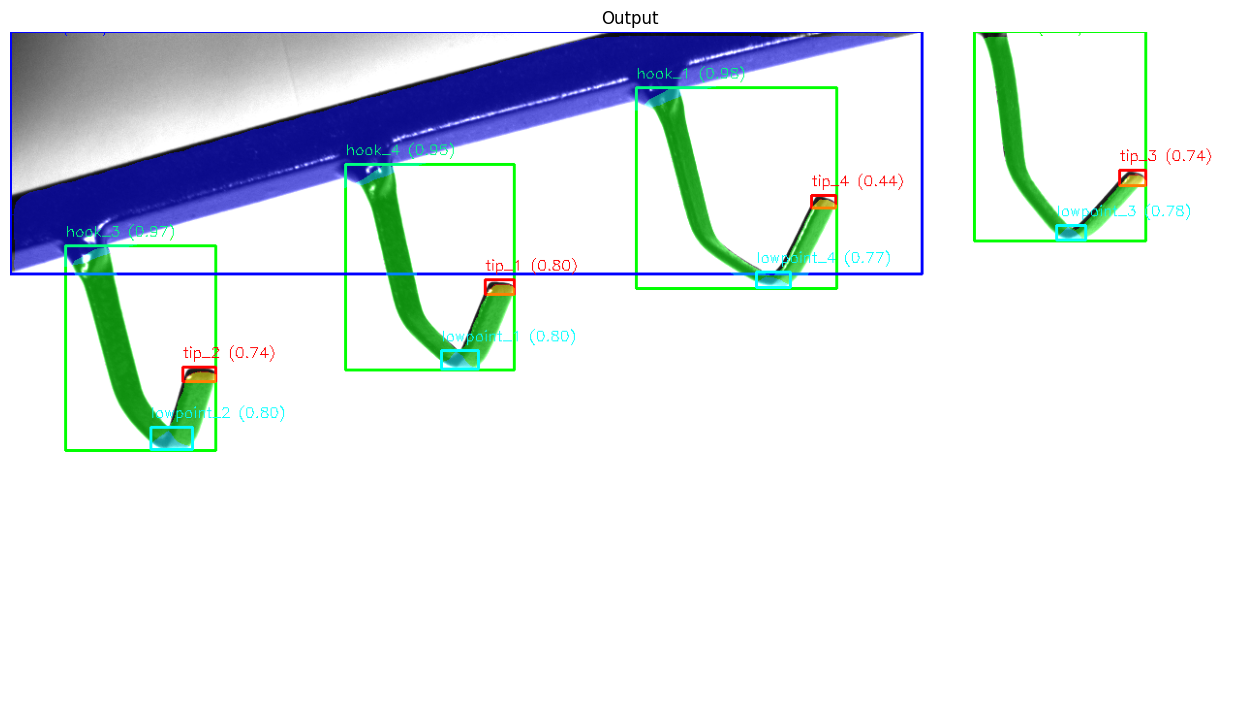

In [29]:
annotated_frame = annotate_frame(frame, results)

plt.figure(figsize=(16, 16))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Output")
plt.show()

***
**Inferenz Laufzeit-Messung**

In [30]:
num_inference_runs = 1000

time_values = []

for inf in range(num_inference_runs):
    start_time = time.perf_counter()
    results = model.predict(source = img_path,
                            device=device,
                            conf = confidence_threshold,
                            iou = 0.7,
                            max_det = max_hooks,
                            visualize = False,
                            classes = [0, 1, 2, 3],
                            retina_masks = True,
                            show_conf=False,
                            show_boxes=False,
                            show_labels=True,
                            save=False,
                            show=False,
                            save_txt=False,
                            save_crop=False,
                            line_width=2,
                            box=False)
    end_time = time.perf_counter()
    time_taken = end_time - start_time
    time_values.append(time_taken)


print(f"Inferenz-Laufzeiten:")
print()

for inference in range(len(time_values)):
    print(f"Inferenz {inference + 1}: {time_values[inference]:.2f} Sekunden")
    print()

print(f"Durchschnittlche Inferenzlaufzeit: {sum(time_values)/(len(time_values)):.4f} Sekunden")
print(f"Durchschnittliche FPS: {len(time_values) / (sum(time_values)):.4f}")


image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929467.png: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 6.3ms
Speed: 1.2ms preprocess, 6.3ms inference, 2.4ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929467.png: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 6.1ms
Speed: 1.3ms preprocess, 6.1ms inference, 2.4ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929467.png: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 2.3ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929467.png: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 5.4ms
Speed: 1.9ms preprocess, 5.4ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929467.png: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 5.8ms
Speed: 1.2ms pre